# Stock Trades by Members of the US House of Representatives

# Summary of Findings


### Introduction

#### Model

##### Predict if a transaction has capitial gains over 200 USD

In this project, we want to estimate if a transaction will have capital gains exceeding \$200 using the provided dataset. We'll need to create a classification model to do this. There are many different classifying models, such as __Decision Tree__, __Random Forest__, __K Mean Clustering__, etc. A boolean column called `cap_gains_over_200_usd` in the transaction dataset will be True if a transaction contains capital gains over \$200 USD. This would be the output label we would be using, and so this made our prediction to be a classifciation problem. We would take into account several columns in our transaction dataset for the input features. As both our baseline model and final model made advantage of several features.

#### Evaluation

For evaulation of our model, we have chosen to use the following metrics:

- Accuracy score $$\text{accuracy} = \frac{\text{# data points classified correctly}}{\text{# data points}} = \frac{TP + TN}{TP + FP + FN + TN}$$
- Precision score $$\text{precision} = \frac{TP}{\text{# predicted positive}} = \frac{TP}{TP + FP}$$
- Recall score $$\text{recall} = \frac{TP}{\text{# actually positive}} = \frac{TP}{TP + FN}$$


### Baseline Model

Baseline Model: [disclosure_year,  disclosure_date(1-6, 7-12)binarizer,  owner(one_hot_encode), type, amount(turn to cat), party(stdByGroup with amount)]

For the baseline model, we believe that the features of `disclosure_year`, `transaction_date`, `owner`, `type`, and `amount` are related to the output of `cap_gain_over_200`.

Total of 7 features are used in the baseline model:

- `disclosure_year`: Categorical ordinal
- `transaction_date`: Categorical ordinal
- `owner`: Categorical nominal
- `type`: Categorical nominal
- `amount`: Quantitative

In the pipeline, we pre-process the input features with the following steps:

1. One-hot encode `disclosure_year`, `owner` and `party` columns.
1. Extract the month of `transaction_date` and then using `Binarizer` to transform it into a boolean Series where month  \le is `False`, otherwise is `True`.
1. Transform the `amount` column into a quantittative feature by calculating the average of thresholds.

#### Performance

Then we process to performing `GridSearchCV` to find out the best parameters for `RandomForestClassifer`. Using the best parameters we have got, our model has the following performance metrics:

##### Confusion matrix

|               | Actually True | Actually False |
| ------------- | ------------- | -------------- |
| Predict True  | 3664          | 28             |
| Predict False | 200           | 27             |

- __Train_Score__ : 93.96%
- __Test_Score__ : 94.18%
- __Accuracy__ : 94.36%
- __Precision__ : 55%
- __Recalls__ : 14.54%


### Final Model

In the Baseline Model: we discovered relatively high accuracy along with high training score and testing score. However, the precision and recalls rate indicate a problem. We then restimated the datasets in the `cap_gain_over_200` and realized unbalanced with True and False ratio of 1:15. With this idea in mind, we can generalize what our baseline model is doing is simply guessing False most of the time and that generate a biased! 

For the Final model, we still believe that the features of `disclosure_year`, `transaction_date`, `owner`, `type`, `amount` and `party` are related to the output of `cap_gain_over_200` so keeping features unchanged.

The approaches we took to eliminate the biasness and perform training are as follow:

Total of 7 features are used in the baseline model:


- `disclosure_year`: Categorical ordinal
- `transaction_date`: Categorical ordinal
- `owner`: Categorical nominal
- `type`: Categorical nominal
- `amount`: Quantitative
- `party`: Categorical nominal

1. Use the `StdScalerByGroup` to calculate the standardized amount of every transaction by their coresponding party.
1. Balance the True False ratio in `cap_gain_over_200` through imblearn. After the balanced, True False ratio becomes 1:1
1. Follow the same pre-process procedures we done in Baseline model to prepared the datasets for analysis.
1. Fit pipline with same steps in baseline.

Using the best parameters we have got, our model has the following Scores and performance metrics:

##### Confusion matrix

|               | Actually True | Actually False |
| ------------- | ------------- | -------------- |
| Predict True  | 4408          | 4              |
| Predict False | 149           | 3534           |

- __Train_Score__ : 87.71%
- __Test_Score__ : 87.53%
- __Accuracy__ : 87.64%
- __Precision__ : 82.30%
- __Recalls__ : 95.95%

Although the score offsets by the increase in observations, but it also leviates the precision and recalls. We believed Final model gives a better explantation than the Baseline model without bias. This Model seems to be GREAT!!
Next is to see how fair is this model generated.

### Fairness Evaluation

However, in terms of fairness our models might introduce bias into the prediction. When running permutation test with the features include in the final model, the red line indicates the score obtained by the classifier on the original data. The score is much better than those obtained by using permuted data and the p-value is thus very low. This indicates that there is a low likelihood that this good score would be obtained by chance alone. It provides evidence that the transaction datasets contains real dependency between features and labels and the classifier was able to utilize this to obtain good results.

# Code

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [4]:
transactions = pd.read_csv('data/congress_trading.csv')
transactions.head()

,Unnamed: 0,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,first_name,last_name,party
0,0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia,foxx,Republican
1,1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia,foxx,Republican
2,2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia,foxx,Republican
3,3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia,foxx,Republican
4,4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,alan,lowenthal,Democrat


### Baseline Model

Baseline Model: [disclosure_year,  disclosure_date(1-6, 7-12)binarizer,  owner(one_hot_encode), type, amount(turn to cat), party(stdByGroup with amount)]

In [5]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class StdScalerByGroup(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def preprocess_(self, df):
        for col in df.columns[1:]:
            df[col] = (df[col]
                       .str.replace(r'[+\-$,]', '', regex=True)
                       .str.replace(r'\s+', ' ', regex=True)
                       .str.strip()
                       .str.split()
                       .apply(lambda x: sum(map(int, x)) // len(x)))
        return df

    def fit(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 2, 2], 'c2': [3, 1, 2, 0]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> std.grps_ is not None
        True
        """
        # X might not be a pandas DataFrame (e.g. a np.array)
        df = self.preprocess_(pd.DataFrame(X))

        # Compute and store the means/standard-deviations for each column (e.g. 'c1' and 'c2'),
        # for each group (e.g. 'A', 'B', 'C').
        # (Our solution uses a dictionary)
        df_agg = df.groupby(df.columns[0]).agg(['mean', 'std'])
        self.grps_ = {(g, c): df_agg.loc[g, c]
                      for g in df_agg.index for c in df_agg.columns}

        return self

    def transform(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 3, 4], 'c2': [1, 2, 3, 4]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> out = std.transform(X)
        >>> out.shape == (4, 2)
        True
        >>> np.isclose(out.abs(), 0.707107, atol=0.001).all().all()
        True
        """

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError(
                "You must fit the transformer before tranforming the data!")

        # Hint: Define a helper function here!
        def helper2(df):
            grp_col = df.columns[0]
            grps = df[grp_col].unique()
            df_grps = df.groupby(grp_col)

            df_out = []
            for grp in grps:
                df_grp = df_grps.get_group(grp).iloc[:, 1:]
                for col in df_grp.columns:
                    df_grp[col] = (
                        df_grp[col] - self.grps_[(grp, (col, 'mean'))]) / self.grps_[(grp, (col, 'std'))]
                df_out.append(df_grp)
            return pd.concat(df_out).fillna(0)

        df = pd.DataFrame(X)

        return helper2(df)

In [6]:
X_bs = transactions[['disclosure_date','owner','type', 'party','amount']]
y_bs = transactions['cap_gains_over_200_usd']

X_tr_bs, X_ts_bs, y_tr_bs, y_ts_bs = train_test_split(X_bs, y_bs, test_size=0.25)

binarize_disclosure_date = Pipeline([
    ('trans_dis_date', FunctionTransformer(lambda x: (x.iloc[:,0].str.split('-', expand=True)[1]).to_frame(), validate=False)),
    ('to_int', FunctionTransformer(lambda x: x.astype('int'))),
    ('binarize', Binarizer(threshold=6))
])

convert_amount = Pipeline([
    ('to_int', FunctionTransformer(lambda x: x.iloc[:,0].str.replace('$', '', regex=True).str.replace(',','',regex=True).str.split(' ',expand=True)[0].to_frame('amount'), validate=False)),
    ('to', FunctionTransformer(lambda x: x.astype('int')))
])

preproc_base = ColumnTransformer(
    transformers = [
        ('disclosure_date', binarize_disclosure_date, ['disclosure_date']),
        ('owner_type', OneHotEncoder(), ['owner', 'type', 'party']),
        ('quant_amount', convert_amount, ['amount'])   
    ]
)

pl_bs = Pipeline([
    ('pre', preproc_base),
    ('classifier', RandomForestClassifier(max_depth=10))
])

pl_bs.fit(X_tr_bs, y_tr_bs)
print('baseline_tr_score', pl_bs.score(X_tr_bs,y_tr_bs))
print('baseline_ts_score', pl_bs.score(X_ts_bs,y_ts_bs))

baseline_tr_score 0.9406210123351765
baseline_ts_score 0.9356978821127838


accuracy_score 0.9356978821127838
precision_score 0.352112676056338
recalls_score 0.10822510822510822


/Users/lijianpeng/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


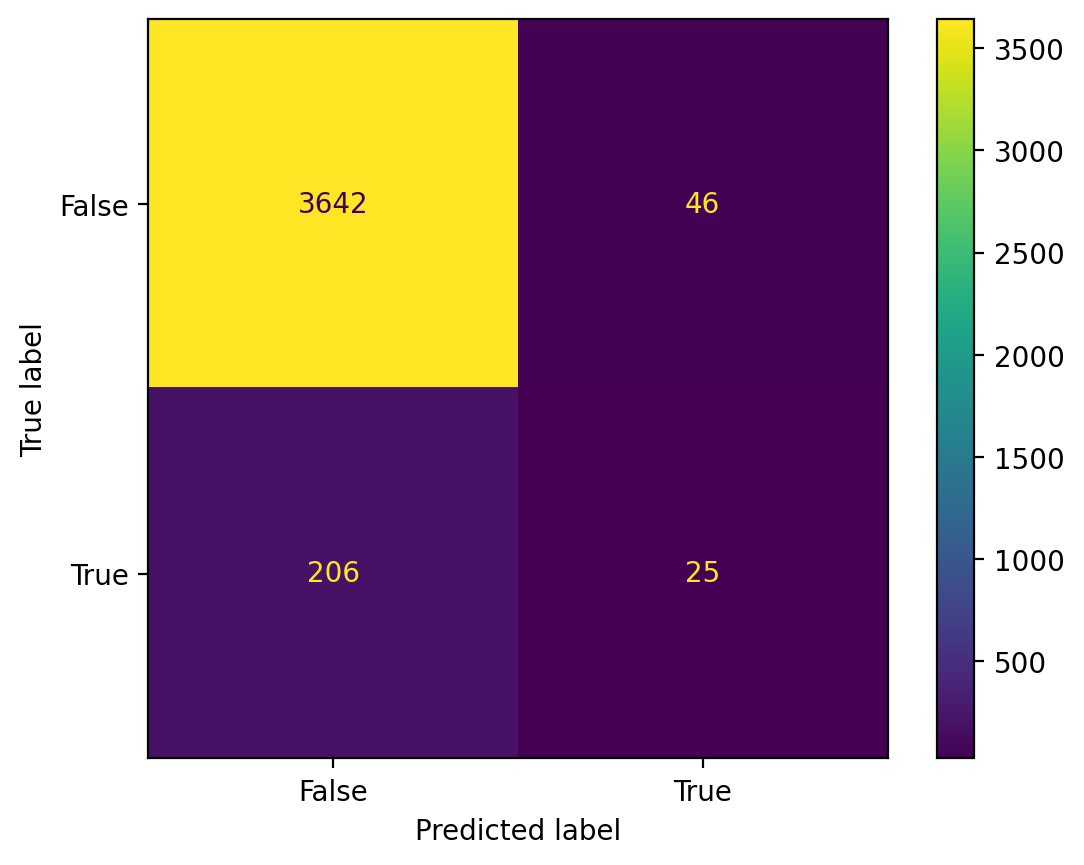

In [7]:
from sklearn import metrics

y_pred_bs = pl_bs.predict(X_ts_bs)
print('accuracy_score', metrics.accuracy_score(y_ts_bs, y_pred_bs))
print('precision_score', metrics.precision_score(y_ts_bs, y_pred_bs))
print('recalls_score', metrics.recall_score(y_ts_bs, y_pred_bs))
metrics.plot_confusion_matrix(pl_bs, X_ts_bs, y_ts_bs);

### Final Model

In [8]:
transactions['cap_gains_over_200_usd'].value_counts()

False    14709
True       965
Name: cap_gains_over_200_usd, dtype: int64

In [9]:
!ln -s /user/project/functions.py functions.py
from stdByGroup import StdScalerByGroup

ln: functions.py: File exists


In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
from imblearn.pipeline import Pipeline as iP

binarize_disclosure_date = Pipeline([
    ('trans_dis_date', FunctionTransformer(lambda x: (x.iloc[:,0].str.split('-', expand=True)[1]).to_frame(), validate=False)),
    ('to_int', FunctionTransformer(lambda x: x.astype('int'))),
    ('binarize', Binarizer(threshold=6))
])

convert_amount = Pipeline([
    ('to_int', FunctionTransformer(lambda x: x.iloc[:,0].str.replace('$', '', regex=True).str.replace(',','',regex=True).str.split(' ',expand=True)[0].to_frame('amount'), validate=False)),
    ('to', FunctionTransformer(lambda x: x.astype('int')))
])

preproc = ColumnTransformer(
    transformers = [
        ('disclosure_date', binarize_disclosure_date, ['disclosure_date']),
        ('owner_type', OneHotEncoder(), ['owner','type', 'party']),
        ('quant_amount', convert_amount, ['amount']),
        ('std_grps', StdScalerByGroup(), ['party', 'amount'])        
    ]
)

ipl = iP([
    ('preproc', preproc),
    ('smt', SMOTE())
])

feature_df = transactions.drop(columns=['cap_gains_over_200_usd'])
label_df = transactions['cap_gains_over_200_usd']

trans_feature_df, trans_label_df = ipl.fit_resample(feature_df, label_df)
balance_transaction = pd.DataFrame(trans_feature_df)


In [18]:
# Baseline Model: 
# [disclosure_year,  disclosure_date(1-6, 7-12)binarizer,  owner(one_hot_encode), type, amount(turn to cat), party(stdByGroup with amount)]
X_fn = balance_transaction
y_fn = trans_label_df

X_tr, X_ts, y_tr, y_ts = train_test_split(X_fn, y_fn, test_size=0.25)

pl = Pipeline([
    ('classifier', RandomForestClassifier(max_depth=10))
])

pl.fit(X_tr, y_tr)
print('Train_sc',pl.score(X_tr, y_tr))
print('Test_sc',pl.score(X_ts, y_ts))
pl.score(balance_transaction, trans_label_df)

Train_sc 0.875356932420795
Test_sc 0.8769544527532291


0.875756339655993

In [13]:
# hyperparameters = {
#     'classifier__max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None], 
#     'classifier__min_samples_split': [2, 3, 5, 7, 10, 15, 20],
#     'classifier__criterion': ['gini', 'entropy']
#     }

# search = GridSearchCV(pl, hyperparameters, cv=5)
# search.fit(X_tr,y_tr)
# search.best_params_

In [14]:
y_pred = pl.predict(X_tr)
y_pred

array([ True,  True,  True, ...,  True,  True, False])

accuracy_score 0.8765465669612509
precision_score 0.8280315713944032
recalls_score 0.9482333607230896


/Users/lijianpeng/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


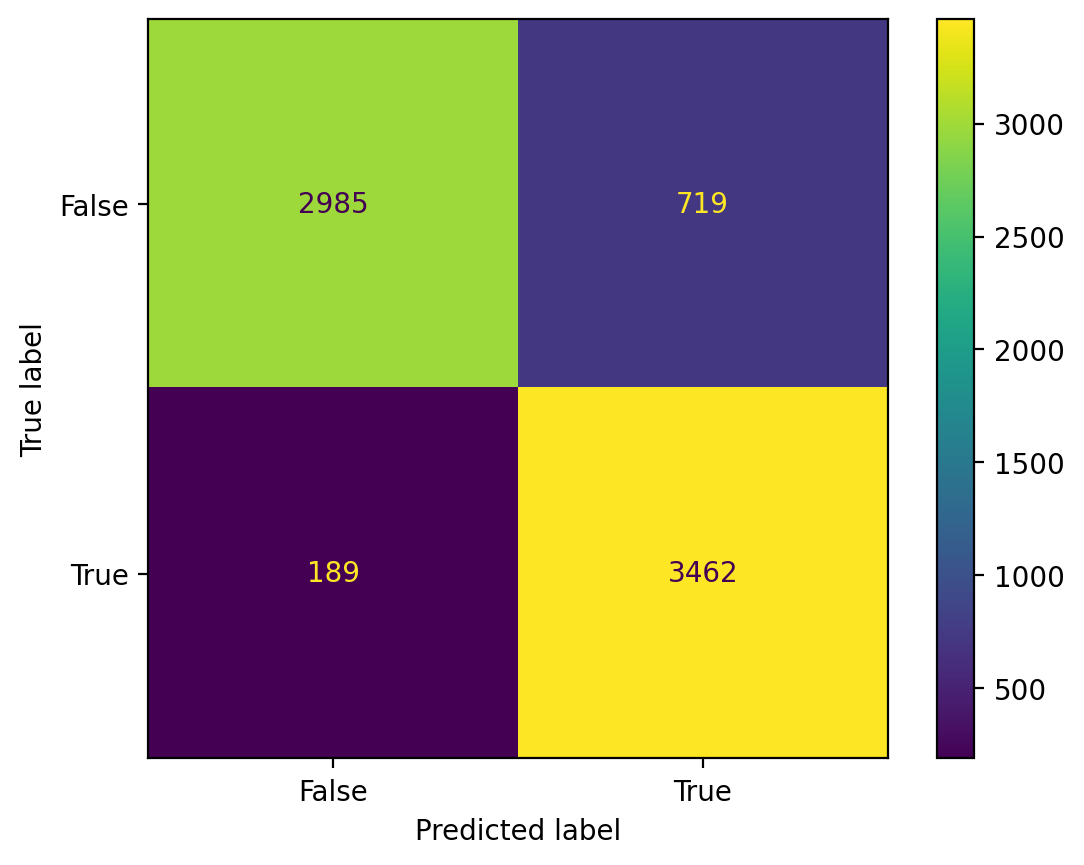

In [15]:
from sklearn import metrics

y_pred = pl.predict(X_ts)
print('accuracy_score', metrics.accuracy_score(y_ts, y_pred))
print('precision_score', metrics.precision_score(y_ts, y_pred))
print('recalls_score', metrics.recall_score(y_ts, y_pred))
metrics.plot_confusion_matrix(pl, X_ts, y_ts);

### Fairness Evaluation

Classification score 0.7985247127608948 (pvalue : 0.009900990099009901)


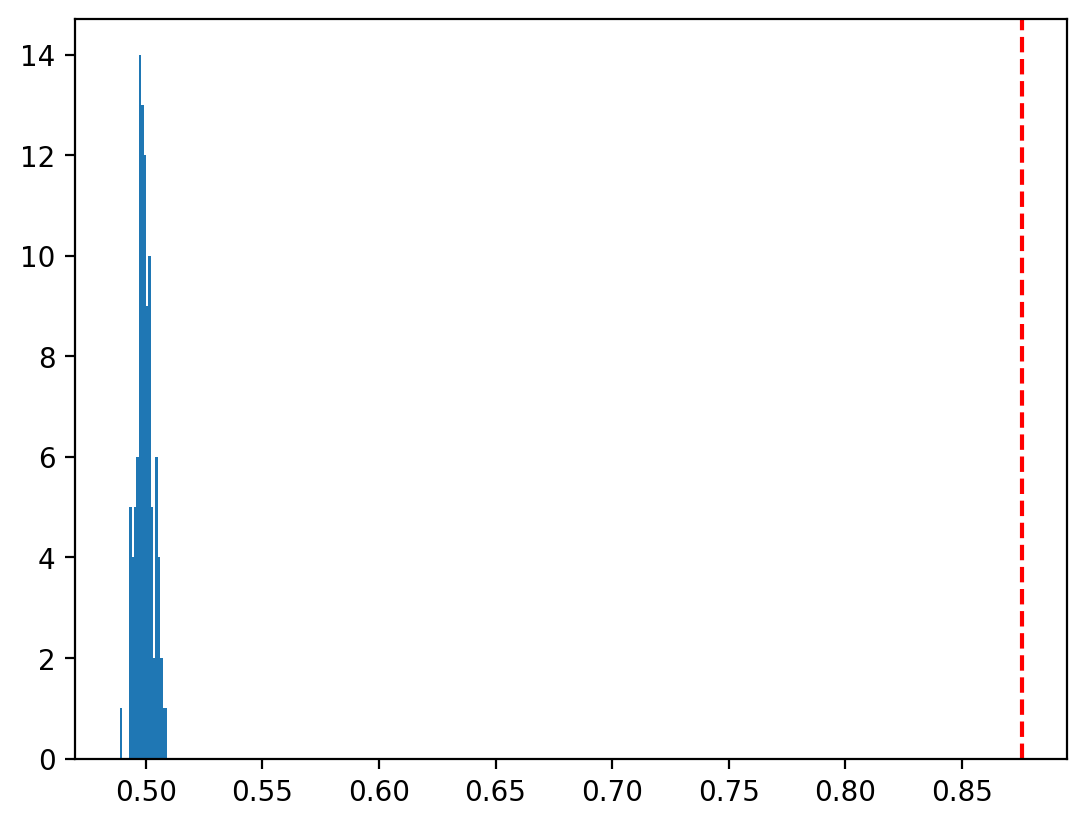

In [20]:
X = X_fn
y = y_fn

import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, permutation_test_score
from sklearn import datasets 

# svm = SVC(kernel='linear')
cv = StratifiedKFold(2)

score, permutation_scores, pvalue = permutation_test_score(
   pl , X, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

ax = plt.axes()
ax.hist(permutation_scores, 20, label='Permutation scores')
ax.axvline(pl.score(balance_transaction, trans_label_df), ls="--", color="r")

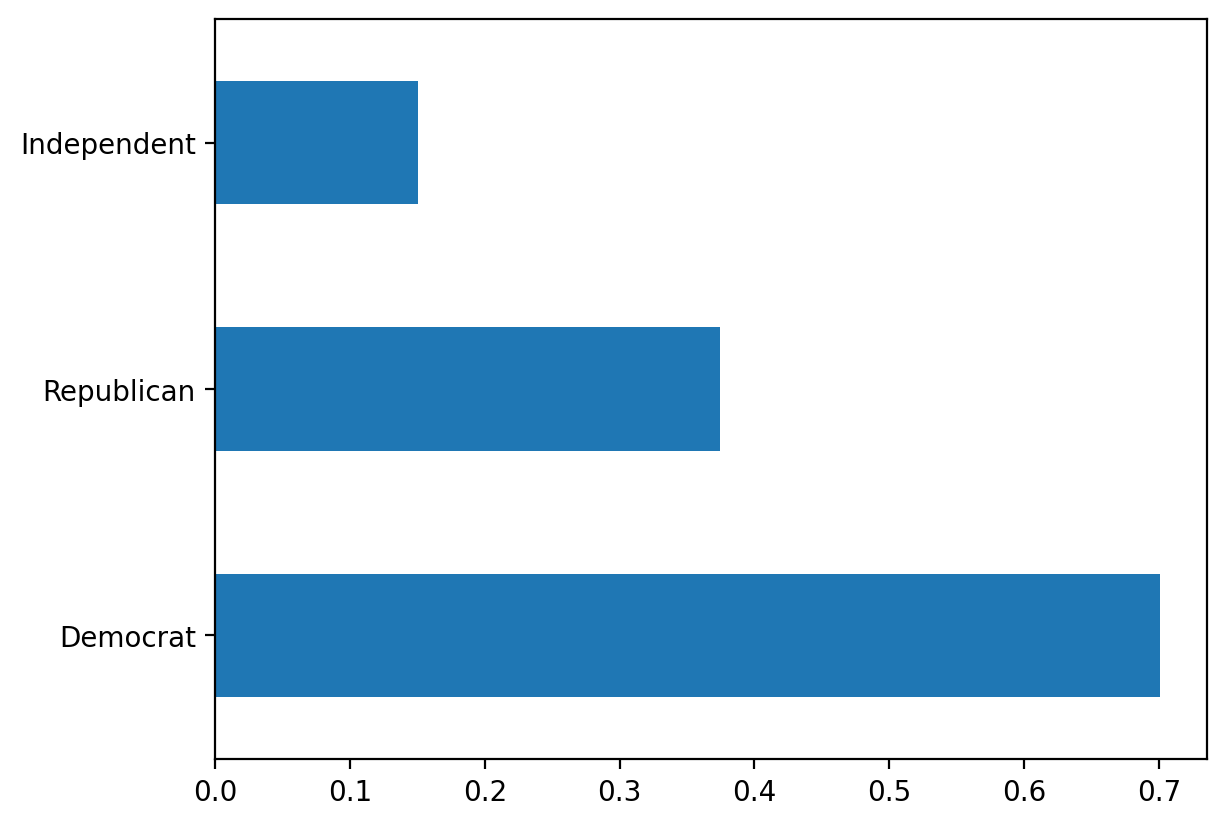

In [149]:
transactions['amount'].value_counts(normalize=True).plot(kind='barh');

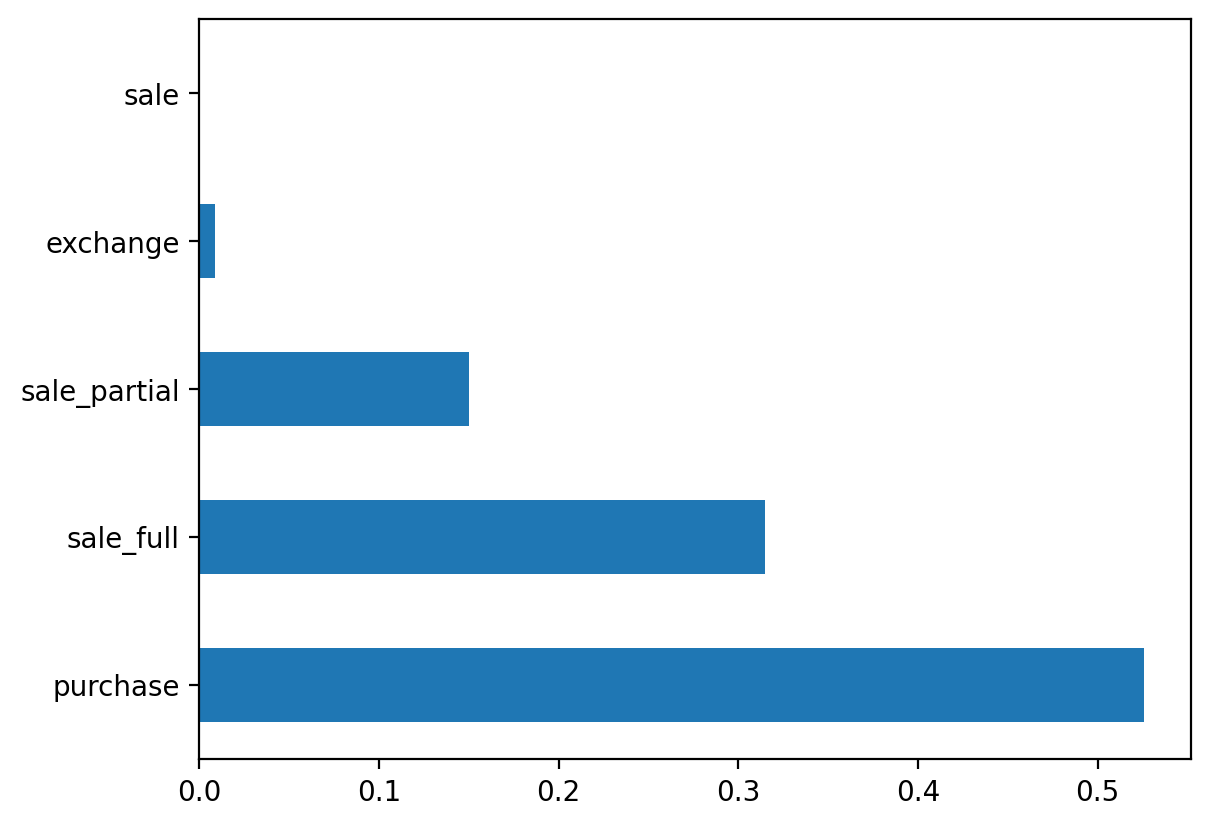

In [150]:
transactions['type'].value_counts(normalize=True).plot(kind='barh');

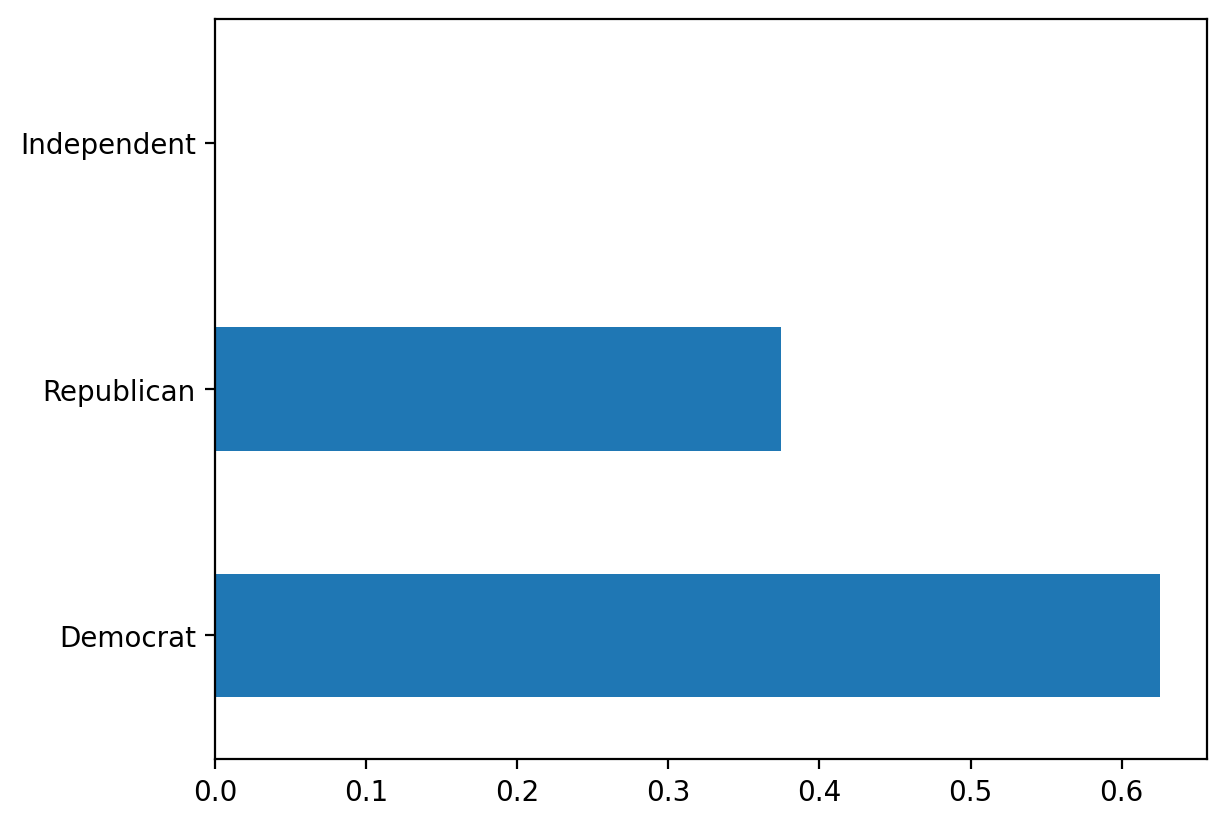

In [151]:
transactions['party'].value_counts(normalize=True).plot(kind='barh');